In [2]:
import netket as nk
import netket.experimental as nkx
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
from netket.models.slater import Slater2nd
from scipy.sparse.linalg import eigsh
import numpy as np
import scipy.sparse.linalg
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt

import sys, os
sys.path.append('/Users/wttai/Documents/Jupyter/machine_learning/common_lib')
sys.path.append('/home1/wttai/machine_learning/common_lib')
from models import get_qwz_graph, get_qwz_Ham
from networks import *
from helper import get_ed_data

In [3]:
L = 2
Lx = 2
Ly = 2
N = Lx * Ly

graph, hi = get_qwz_graph(L = Lx, L2 = Ly, pbc = False, N = N)

m = 5.0
t = 1.0
U = 4.0
s = 0
p = 1
learning_rate = 0.01
diag_shift = 0.01

H = get_qwz_Ham(hi, graph, m = m, t = t, U = U)

# Exact diagonalization

evals, evecs = get_ed_data(H, k = 6)
E_gs = evals[0]

Exact ground state energy: -20.579182482763795


In [8]:
s, p = 1, -1
def corr_func(i):
    return cdag(hi, i, s) * c(hi, 0, s) + cdag(hi, i, p) * c(hi, 0, p)

In [9]:
corrs = {}
for i in range(N):
    corrs[f"cdag{i}c0"] = corr_func(i)

# Slater Determinant

In [50]:
n_iter = 300
# Create the Slater determinant model
model = Slater2nd(hi, generalized=True)#LogSlaterDeterminant(hi)

# Define the Metropolis-Hastings sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=learning_rate)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=diag_shift)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
slater_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=n_iter, out=slater_log, obs = corrs)

  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['cdag0c0', 'cdag1c0', 'cdag2c0', 'cdag3c0', 'acceptance', 'Energy'],)

In [51]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -15.51+0.53j ± 0.20 [σ²=114.56, R̂=1.0374]
Relative error   : 0.2478252247661863


In [16]:
# Create a Neural Jastrow Slater wave function 
model = LogNeuralJastrowSlater(hi, hidden_units=N)

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=learning_rate)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=diag_shift)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
nj_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=nj_log)

  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [17]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -20.3229-0.0751j ± 0.0094 [σ²=0.2032, R̂=1.0586]
Relative error   : 0.012976785166341947


In [10]:
# Create a neural backflow wave function
model = LogNeuralBackflow(hi, hidden_units=N)

# Define a Metropolis exchange sampler
#sa = nk.sampler.MetropolisExchange(hi, graph=graph)
sa = nk.sampler.MetropolisLocal(hi)
#sa = nk.sampler.ExactSampler(hi) 

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=diag_shift)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bf_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=bf_log)

  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [11]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -20.187-0.007j ± 0.050 [σ²=3.271, R̂=1.0302]
Relative error   : 0.019083358823917304


In [7]:
nj_log

NameError: name 'nj_log' is not defined

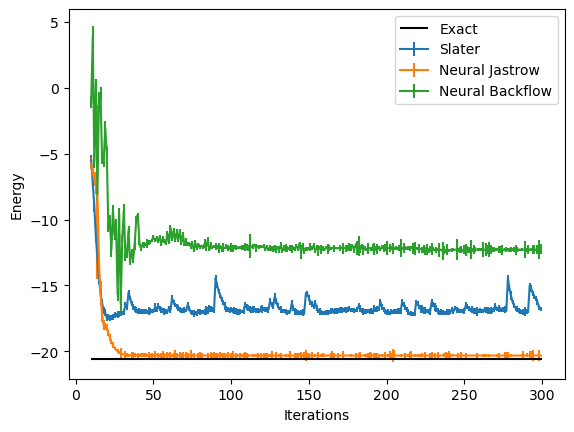

In [43]:
logged_data = (slater_log.data,nj_log.data,bf_log.data)
labels = ("Slater","Neural Jastrow","Neural Backflow")

from matplotlib import pyplot as plt

start = 10

end = 300

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters[start:end], data["Energy"].Mean.real[start:end], yerr=data["Energy"].Sigma[start:end],label=label)

plt.hlines([E_gs], xmin=start, xmax=end, color='black', label="Exact")

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()

In [47]:
class LogNeuralBackflowRevised(nn.Module):
    hilbert: nkx.hilbert.SpinOrbitalFermions
    hidden_units: int
    kernel_init: NNInitFunc = default_kernel_init
    param_dtype: DType = float

    @nn.compact
    def __call__(self, n):
        # n: shape (batch_size, hilbert.size)
        batch_size = n.shape[0]
        N = self.hilbert.size
        Nf = self.hilbert.n_fermions

        # Bare Slater Determinant (N x Nf matrix of the orbital amplitudes)
        M = self.param('M', self.kernel_init, (N, Nf), self.param_dtype)

        # Neural Backflow: modify M based on n
        F = nn.Dense(self.hidden_units, param_dtype=self.param_dtype)(n)
        F = jax.nn.tanh(F)
        F = nn.Dense(N * Nf, param_dtype=self.param_dtype)(F)
        F = F.reshape((batch_size, N, Nf))

        # Modify M for each sample in the batch
        M_modified = M + F  # Broadcasting over batch dimension

        # Find the positions of the occupied orbitals for each sample
        def get_occupied_indices(n_single):
            return jnp.nonzero(n_single, size=Nf)[0]

        occupied_indices = jax.vmap(get_occupied_indices)(n)

        # Extract the occupied rows for each sample
        def get_A(M_mod_single, occ_idx_single):
            return M_mod_single[occ_idx_single, :]

        A = jax.vmap(get_A)(M_modified, occupied_indices)

        # Compute the log determinant for each sample
        log_det = jax.vmap(nk.jax.logdet_cmplx)(A)

        return log_det


In [54]:
# Create a neural backflow wave function
model = LogNeuralBackflowRevised(hi, hidden_units=N)

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=diag_shift)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bf_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=bf_log)

  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [53]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -11.39+0.66j ± 0.14 [σ²=54.48, R̂=1.0306]
Relative error   : 0.447562682755657
